<div class="alert alert-block alert-warning">
<b>Costs:</b> This QPU simulation costs ??? dollars.
</div>

<div class="alert alert-block alert-success">
<b>This simulation finds ground state energy for H2 molecule. </b>
<div>Obs. 1: The data is saved in external files so that it can be worked on without incurring new costs.</div>
<div>Obs. 2: For new simulation parameters, save in a file with a different name.</div>
</div>

# Instructions if you are running outside AWS cloud

1. Install aws-cli:

`sudo apt install aws-cli`

2. Setup aws credentials:

`aws configure --profile "default"`

3. Create virtual environment 

`python -m venv /path/to/new/virtual/environment`

4. Activate virtual environment

`source /path/to/new/virtual/environment/bin/activate`

In [1]:
from boto3 import Session
from braket.aws import AwsSession

# Start Boto3 Session with your credentials profile
boto_session = Session(profile_name='default')

# Initialize Braket session with Boto3 Session credentials
aws_session = AwsSession(boto_session=boto_session)

# Defining the function to save results to json file and read results from file

In [2]:
import json

def save_to_file(data, file_name):
    with open(file_name+".json", "w") as file:
        json.dump(data, file, indent=4)

def read_from_file(file_name):
    with open(file_name+".json", 'r') as file:
        data = json.load(file)
    return data

# Importando Backends - Computadores Quânticos

In [3]:
from braket.aws import AwsDevice

for d in AwsDevice.get_devices():
    print(f"{d.name:20}  |  {d.provider_name:10} |  {d.arn}")

Ankaa-3               |  Rigetti    |  arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3
Aquila                |  QuEra      |  arn:aws:braket:us-east-1::device/qpu/quera/Aquila
Aria 1                |  IonQ       |  arn:aws:braket:us-east-1::device/qpu/ionq/Aria-1
Aria 2                |  IonQ       |  arn:aws:braket:us-east-1::device/qpu/ionq/Aria-2
Emerald               |  IQM        |  arn:aws:braket:eu-north-1::device/qpu/iqm/Emerald
Forte 1               |  IonQ       |  arn:aws:braket:us-east-1::device/qpu/ionq/Forte-1
Forte Enterprise 1    |  IonQ       |  arn:aws:braket:us-east-1::device/qpu/ionq/Forte-Enterprise-1
Garnet                |  IQM        |  arn:aws:braket:eu-north-1::device/qpu/iqm/Garnet
SV1                   |  Amazon Braket |  arn:aws:braket:::device/quantum-simulator/amazon/sv1
TN1                   |  Amazon Braket |  arn:aws:braket:::device/quantum-simulator/amazon/tn1
dm1                   |  Amazon Braket |  arn:aws:braket:::device/quantum-simulator/ama

# PES CO2
### Definição

In [ ]:
# PES CO2 (symmetric stretch O–C–O) with VQE (PennyLane + PySCF)
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import matplotlib.pyplot as plt

# -----------------------------------------
# Configurações principais
# -----------------------------------------
basis      = "sto-3g"
charge     = 0
multip     = 1

# Active space:
# nº de elétrons ativos (pares mais externos) e nº de ORBITAIS ESPACIAIS ativos
active_e  = 8        # comece com 8; CO2 tem 16 valência (4 de C + 6+6 de O)
active_orb = 8       # nº de orbitais espaciais ativos (spin-orbitais = 2*active_orb)

# Varredura C–O (Å)
R_range = np.linspace(1.5, 1.7, 8)  # pegue em torno de 1.16 Å

# Otimizador
steps = 120
stepsize = 0.25

energies = []
params_cache = None  # warm start

### Otimização

In [ ]:
for k, R in enumerate(R_range):
    # Geometria linear: O(-R,0,0), C(0,0,0), O(+R,0,0)  (unidades em Å)
    symbols = ["O", "C", "O"]
    coords  = np.array([
        [-R, 0.0, 0.0],
        [ 0.0, 0.0, 0.0],
        [ R, 0.0, 0.0],
    ]).reshape(-1)

    # Hamiltoniano de 2º-quantização + nº de qubits
    H, n_qubits = qchem.molecular_hamiltonian(
        symbols,
        coords,
        method="pyscf",
        basis=basis,
        charge=charge,
        mult=multip,
        # Active space ↓ (em orbitais **espaciais** e elétrons)
        active_electrons=active_e,
        active_orbitals=active_orb,
        mapping="jordan_wigner",
        outpath=None,
    )

    # HF state (em número de SPIN-orbitais = n_qubits)
    hf = qchem.hf_state(electrons=active_e, orbitals=n_qubits)

    # ---- gerar excitações (compatível com PL novo e antigo) ----
    try:
        # API nova: retorna duas listas
        singles, doubles = qchem.excitations(active_e, n_qubits)
    except TypeError:
        # API antiga: retorna lista única; se cair aqui, faça o split por tamanho
        exc = qchem.excitations(active_e, n_qubits)
        singles = [e for e in exc if len(e) == 2]
        doubles = [e for e in exc if len(e) == 4]

    # sanity-check rápido para evitar o erro do template
    if not singles and not doubles:
        raise RuntimeError("Nenhuma excitação gerada: verifique nelec/norb do active space.")

    # Dispositivo e QNode
    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, interface="autograd")
    def vqe_circuit(theta):
        # UCCSD compacto; o template prepara HF automaticamente se passarmos hf_state
        qml.AllSinglesDoubles(
            theta,
            wires=range(n_qubits),
            hf_state=hf,
            singles=singles,
            doubles=doubles,
        )
        return qml.expval(H)

    # nº de parâmetros = nº de excitações (S + D)
    n_params = len(singles) + len(doubles)

    # warm start dos parâmetros
    theta = np.zeros(n_params, requires_grad=True) if params_cache is None else params_cache

    opt = qml.GradientDescentOptimizer(stepsize=stepsize)
    prev_E = 1e9
    for s in range(steps):
        theta, E = opt.step_and_cost(vqe_circuit, theta)
        if abs(E - prev_E) < 1e-6:
            break
        prev_E = E

    params_cache = theta  # guarda para o próximo ponto da curva
    energies.append(float(E))
    print(f"R = {R:.3f} Å  |  E = {E:.8f} Ha  |  iters={s+1}")


R = 0.950 Å  |  E = -171.02915533 Ha  |  iters=11


### Plot

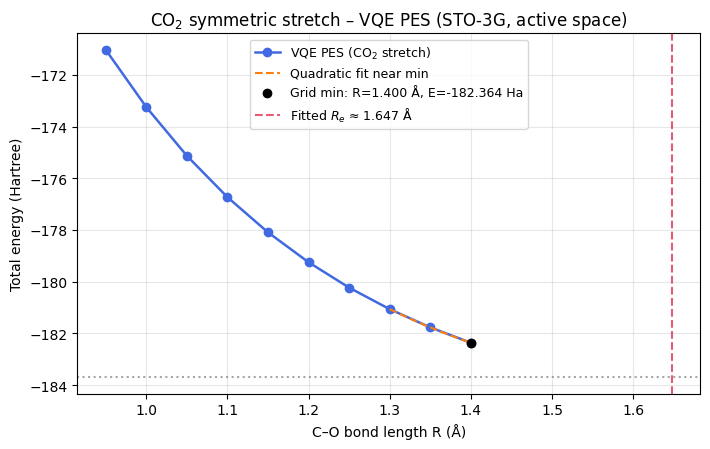

Grid minimum:      R = 1.4000 Å,  E = -182.363912 Ha
Fitted equilibrium: R_e ≈ 1.6474 Å,  E ≈ -183.701188 Ha
ΔE(last point − min) ≈ 0.000000 Ha


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ----- dados da varredura -----
R = np.asarray(R_range, dtype=float)       # Å
E = np.asarray(energies, dtype=float)      # Hartree

# mínimo na malha
imin = int(np.argmin(E))
R_grid_min = float(R[imin])
E_grid_min = float(E[imin])

# ajuste quadrático em torno do mínimo (usa ~5 pontos, ou o que couber nas bordas)
i0 = max(0, imin - 2)
i1 = min(len(R), imin + 3)
coef = np.polyfit(R[i0:i1], E[i0:i1], 2)           # E(R) ≈ aR^2 + bR + c
R_fit = np.linspace(R[i0], R[i1-1], 300)
E_fit = np.polyval(coef, R_fit)
R_min_fit = -coef[1] / (2*coef[0])                 # vértice da parábola
E_min_fit = np.polyval(coef, R_min_fit)

# (opcional) energia de dissociação relativa ao último ponto da curva
De = E[-1] - E_grid_min

# ----- plot -----
fig, ax = plt.subplots(figsize=(7.2, 4.6))
ax.plot(R, E, 'o-', lw=1.8, color='royalblue', label='VQE PES (CO$_2$ stretch)')
ax.plot(R_fit, E_fit, '--', color='tab:orange', label='Quadratic fit near min')

# marcações do mínimo
ax.scatter([R_grid_min], [E_grid_min], color='k', zorder=3,
           label=f'Grid min: R={R_grid_min:.3f} Å, E={E_grid_min:.3f} Ha')
ax.axvline(R_min_fit, ls='--', color='crimson', alpha=.7,
           label=f'Fitted $R_e$ ≈ {R_min_fit:.3f} Å')
ax.axhline(E_min_fit, ls=':', color='gray', alpha=.7)

ax.set_xlabel('C–O bond length R (Å)')
ax.set_ylabel('Total energy (Hartree)')
ax.set_title('CO$_2$ symmetric stretch – VQE PES (STO-3G, active space)')
ax.grid(alpha=0.3)
ax.legend(loc='best', fontsize=9)
plt.tight_layout()
plt.show()

print(f"Grid minimum:      R = {R_grid_min:.4f} Å,  E = {E_grid_min:.6f} Ha")
print(f"Fitted equilibrium: R_e ≈ {R_min_fit:.4f} Å,  E ≈ {E_min_fit:.6f} Ha")
print(f"ΔE(last point − min) ≈ {De:.6f} Ha")